<a href="https://colab.research.google.com/github/lizhieffe/llm_knowledge/blob/main/kaggle/neurips_2025_google_code_golf_championship/vLLM_Inference_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This colab is for the championship: https://www.kaggle.com/competitions/google-code-golf-2025/overview

Note
- The Ollama Eval colab: https://github.com/lizhieffe/llm_knowledge/blob/main/kaggle/neurips_2025_google_code_golf_championship/Eval_with_Ollama.ipynb

# TLDR

## Model Quality Comparison

The 400 data points eval results are used to measure the quality.

> Note: most of the model names are for Ollama; you can map to the equivalent vLLM (HF) model names yourself.

| Model | thinking enabled | Valid Code Rate | Correct Code Rate |
| :--- | :--- | :--- | :--- |
| **W3S** | True | 0.78 | 0.06 |
| **W3M** | True | 0.47 | 0.04 |
| **qwen2.5-coder:0.5b** | True | 0.04 | 0.00 |
| **qwen2.5-coder:1.5b** | True | 0.15 | 0.00 |
| **qwen2.5-coder:7b** | True | 0.34 | 0.01 |
| **qwen2.5-coder:14b** | True | 0.39 | 0.03 |
| **qwen3-coder:30b** | True | 0.61 | 0.11 |
| **deepseek-coder:1.3b** | True | 0.00 | 0.00 |
| **deepseek-coder:6.7b** | True | 0.19 | 0.01 |
| **deepseek-coder:33b** | True | 0.20 | 0.05 |
| **cpatonn/Qwen3-Coder-30B-A3B-Instruct-AWQ-4bit** (FP8 KV quant) | True | 0.51 | 0.07 |
| **cpatonn/Qwen3-Coder-30B-A3B-Instruct-AWQ-4bit** (FP8 KV quant) | False | 0.53 | 0.06 |


## Model Feasibility Comparison

| Model | `max_model_len` | `kv_cache_dtype` | GPU | Result |
| :--- | :--- | :--- | :--- | :--- |
| **Qwen/Qwen3-4B** | `default` | `default` | L4 | ✅ Works |
| | `default` | `default` | A100 | ✅ Works |
| **Qwen/Qwen3-8B** | `default` | `default` | L4 | ❌ Doesn't Work |
| | `default` | `default` | A100 | ✅ Works |
| | `4096` | `default` | L4 | ✅ Works |
| **Qwen/Qwen3-14B** | `default` | `default` | L4 | ❌ Doesn't Work |
| | `default` | `default` | A100 | ✅ Works |
| | `2048` | `default` | L4 | ❌ Doesn't Work |
| **Qwen/Qwen3-32B** | `3072` | `default` | A100 | ❌ Doesn't Work |
| **Qwen3-Coder-30B-FP8** | `3072` | `default` | A100 | ✅ Works |
| | `4096` | `default` | A100 | ❌ Doesn't Work |
| **Qwen3-Coder-30B-AWQ** | `4K` | `default` | L4 | ✅ Works |
| | `5K` | `default` | L4 | ❌ Doesn't Work |
| | `12K` | `fp8` | L4 | ✅ Works |
| | `16K` | `fp8` | L4 | ❌ Doesn't Work |

## Performance

| `MODEL_ID` | `GPU` | `Engine` | `MAX_MODEL_LEN` | `kv_cache_dtype` | Thinking | Speed | Throughput |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| `cpatonn/Qwen3-Coder-30B-A3B-Instruct-AWQ-4bit` | L4 | vLLM | `8192` | `fp8` | True | `7s/it` | `200 toks/s` |
| `Qwen/Qwen3-32B` | L4 | `Ollama` | `default` | `N/A` | True | `43s/it` | `?` |
| `cpatonn/Qwen3-Coder-30B-A3B-Instruct-AWQ-4bit` | A100 | vLLM | `8192` | `fp8` | True | `15s/it` | `122 toks/s` |
| `cpatonn/Qwen3-Coder-30B-A3B-Instruct-AWQ-4bit` | A100 | vLLM | `8192` | `fp8` | False | `7.3s/it` | `122 toks/s` |



In [1]:
from typing import Sequence

# Public Interface

In [2]:
from typing import Any

import dataclasses
import numpy as np


@dataclasses.dataclass
class DataPoint:
  # A list of (input, output) tuples
  # train: list[tuple[np.ndarray, np.ndarray]]
  train: list[tuple[Sequence[Sequence[int]], Sequence[Sequence[int]]]]
  train_raw: list[dict]

  # (input, output) tuple
  # test: list[tuple[np.ndarray, np.ndarray]]
  test: list[tuple[Sequence[Sequence[int]], Sequence[Sequence[int]]]]
  test_raw: list[dict]

  json_dict: dict[str, Any]

# Download data and load

In [3]:
# @title Setup Kaggle credential

# Option 1 - Load kaggle secret from the Colab's Secrets
#
# This requires to save the download kaggle secrect json file's content to the colab's Secrets with name "kaggle"
import os
from google.colab import userdata
kaggle_secret_json = userdata.get('kaggle')
os.environ['env_var_kaggle_secret_json'] = kaggle_secret_json

!mkdir -p ~/.kaggle/ && > ~/.kaggle/kaggle.json && echo $env_var_kaggle_secret_json >> ~/.kaggle/kaggle.json && chmod 600 ~/.kaggle/kaggle.json

# Option 2 - Upload kaggle secret from local file
#
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [4]:
# @title Download data

%%capture


import os

base_path = "/content/google-code-golf-2025"

if not os.path.isdir(base_path):
  !pip install --user kaggle
  !kaggle competitions download -c google-code-golf-2025
  !unzip /content/google-code-golf-2025.zip -d /content/google-code-golf-2025/

In [5]:
# @title Parse the data

import json
import os

import numpy as np

print(f"Attempting to list files in: {base_path}")

# This returns a list of filename strings. It doesn't include the path.
files = os.listdir(base_path)
json_file_paths = [
    os.path.join(base_path, f) for f in files if f.endswith(".json")
]
print(f"Found {len(json_file_paths)} json files")

def extract_data_point(json_filepath: str) -> DataPoint:
  """Extract DataPoint from a json file.

  Args:
    json_filepath: The path to the json file.

  Returns:
    A DataPoint object.
  """
  with open(json_filepath, "rt") as my_file:
    content = my_file.read()
    json_dict = json.loads(content)

    train_val = json_dict["train"]
    all_train = [
        (it["input"], it["output"]) for it in train_val
    ]
    train_raw = train_val

    test_val = json_dict["test"]
    all_test = [
        (it["input"], it["output"]) for it in test_val
    ]
    test_raw = test_val

    return DataPoint(
        train=all_train, train_raw=train_raw, test=all_test, test_raw=test_raw, json_dict=json_dict
    )


import tqdm
import concurrent.futures

with concurrent.futures.ThreadPoolExecutor(
    max_workers=min(512, len(json_file_paths)), thread_name_prefix="Worker"
) as executor:
  # The map() function is the key.
  # It applies 'worker_task' to each item in 'items_to_process'.
  # It automatically collects the results and returns them as an iterator.
  data_points = list(
      tqdm.tqdm(
          executor.map(extract_data_point, json_file_paths),
          total=len(json_file_paths),
      )
  )
  print(f"{len(data_points)=}")
  print(f"An example of the data points {data_points[0]}")

Attempting to list files in: /content/google-code-golf-2025
Found 400 json files


100%|██████████| 400/400 [00:00<00:00, 319322.73it/s]

len(data_points)=400
An example of the data points DataPoint(train=[([[0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0], [0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[4, 0, 0, 0, 0, 0, 0, 0, 0,

In [6]:
# @title Install vLLM and dependencies

%%capture

# The 0.10 version of vLLM doesn't load model successfully. So we use 0.9.2 version

# Similar bugs
#   https://github.com/vllm-project/vllm/issues/17618
!pip install vllm==0.9.2 lm-format-enforcer pandas

# This is needed to be compatible with vLLM 0.9.2.
#
# For issue: https://github.com/vllm-project/vllm/issues/17618
!pip install "transformers<4.54.0"

!pip show vllm

# Generation libs

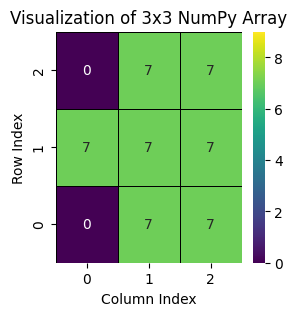

In [7]:
# @title Visualization libs

import matplotlib.pyplot as plt
import seaborn as sns # Optional, for slightly nicer colorbars and default styles

def visualize_np_array(np_array):
    """
    Visualizes a 2D NumPy array (rectangular matrix of integers between 0 and 9)
    as a heatmap.

    Args:
        np_array (np.ndarray): The NumPy array to visualize.
                               Expected shape: (rows, cols)
                               Expected values: integers between 0 and 9.
    """
    if not isinstance(np_array, np.ndarray):
        np_array = np.array(np_array)

    if np_array.ndim != 2:
        print(f"Error: Input array must be 2-dimensional, but has {np_array.ndim} dimensions.")
        return

    rows, cols = np_array.shape

    if not (1 <= rows <= 30 and 1 <= cols <= 30):
        print(f"Error: Array dimensions ({rows}x{cols}) are outside the allowed range (1x1 to 30x30).")
        return

    # Check if all values are integers between 0 and 9
    if not (np.all(np_array >= 0) and np.all(np_array <= 9) and np.all(np_array == np_array.astype(int))):
        print("Warning: Array contains values outside the 0-9 integer range. Visualization might be misleading.")
        # Attempt to cast to int to prevent issues with imshow expecting numeric data
        np_array = np_array.astype(int)

    # Set up the plot
    image_zoom_factor = 1.0 if rows <= 10 and cols <= 10 else 0.5
    plt.figure(figsize=(cols * image_zoom_factor, rows * image_zoom_factor)) # Adjust figure size dynamically for better aspect ratio

    # Use seaborn's heatmap for a more aesthetically pleasing visualization
    # 'cmap' defines the color map. 'viridis' is a good default for sequential data.
    # 'RdYlGn' (Red-Yellow-Green) or 'Greens' are also good options.
    # 'annot=True' will display the value in each cell (useful for small grids)
    # 'fmt="d"' ensures the annotation is an integer
    # 'cbar=True' shows the color bar
    # 'linewidths' and 'linecolor' add borders between cells
    sns.heatmap(np_array, annot=True, fmt="d", cmap="viridis", cbar=True,
                linewidths=0.5, linecolor='black', vmin=0, vmax=9)

    plt.title(f'Visualization of {rows}x{cols} NumPy Array')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.xticks(np.arange(cols) + 0.5, labels=np.arange(cols)) # Center ticks
    plt.yticks(np.arange(rows) + 0.5, labels=np.arange(rows)) # Center ticks
    plt.gca().invert_yaxis() # Invert y-axis to have (0,0) at top-left like typical arrays

    plt.show()

array = np.array([[0, 7, 7], [7, 7, 7], [0, 7, 7]])
visualize_np_array(array)

In [8]:
# @title Prompt Libs
SYSTEM_TURN = """You are a principle software engineer.

"""


USER_TURN_PREFIX = """You should implement a Python function to do a transformation, which is implicitly described by pairs of <input, output> image grids. The transformation may include rotation, cropping, magnification, etc. Your code should achieve the desired result across all exemplars, and uses the fewest possible number of characters.

A "grid" is a rectangular matrix (list of lists) of integers between 0 and 9 (inclusive). The size is between 1x1 and the 30x30.

The function name is "fn". Its signature is `fn(input: typing.Sequence[typing.Sequence[int]]) -> typing.Sequence[typing.Sequence[int]]:`.

Do NOT use any external library!

Examplars:

"""


def build_prompt(data_point: DataPoint) -> list[dict[str, str]]:
  user_turn = USER_TURN_PREFIX

  # Remove the whitespace in list of integers string to save tokens.
  grid_pairs_str = str(data_point.train_raw)
  len_before = len(grid_pairs_str)
  grid_pairs_str = grid_pairs_str.replace(", ", ",")
  user_turn += grid_pairs_str

  messages = [
      {"role": "system", "content": SYSTEM_TURN},
      {"role": "user", "content": user_turn},
  ]
  return messages


# Test
conversation = build_prompt(data_points[0])
print(f"Prompt = {conversation}")

Prompt = [{'role': 'system', 'content': 'You are a principle software engineer.\n\n'}, {'role': 'user', 'content': 'You should implement a Python function to do a transformation, where the transformation is implicitly described by multiple pair of <input, output> image grids that are given. For example, the example pairs for one task might demonstrate the concept of rotation, whereas another might involve cropping and/or magnification. Your code for a given task should not only achieve the desired result across all exemplars, but also do so using the fewest possible number of characters.\n\nA "grid" is a rectangular matrix (list of lists) of integers between 0 and 9 (inclusive). The smallest possible grid size is 1x1 and the largest is 30x30.\n\nThe function should have name "fn". Its signature is `fn(input: typing.Sequence[typing.Sequence[int]]) -> typing.Sequence[typing.Sequence[int]]:`.\n\nDo NOT use any external library!\n\nExamplars:\n\n[{\'input\': [[0, 0, 4, 0, 0, 0, 0, 0, 0, 0,

In [9]:
# @title Generate Code Libs

def extract_code_from_resp(resp_str: str) -> str:
  prefix = "```python"
  suffix = "```"
  while True:
    prefix_idx = resp_str.find(prefix)
    if prefix_idx != -1:
      resp_str = resp_str[prefix_idx + len(prefix) :]
    else:
      break
  suffix_idx = resp_str.find(suffix)
  if suffix_idx != -1:
    resp_str = resp_str[: suffix_idx]
  return resp_str.strip()

In [10]:
# @title JIT Python execution libs

import typing
import numpy as np


def exec_and_ret(code_str: str, input: np.ndarray) -> typing.Any:
  """Execute a string of code and return the result.

  The result must be assigned to a variable named 'ret'.

  Args:
    code_str: A string of code.
    input: the input to the code.

  Returns:
    The result of the code.
  """
  loc = {}
  exec(code_str, {'input': input}, loc)
  return loc['ret']


# # Test
# code_str = """ret = 1 + 2"""
# assert 3 == exec_and_ret(code_str, input)

In [11]:
# @title Verification libs
!pip install func-timeout

from typing import Any
from func_timeout import func_timeout, FunctionTimedOut


def verify_code_dp(
    code_str: str, data_point: DataPoint, visualize: bool = False, timeout_seconds:int = 30
) -> tuple[bool, Any, str|None]:
  """Verify the given code on its expected result."""
  assert data_point.test
  # inp = data_point.test[0][0].tolist()
  # expected_output = data_point.test[0][1].tolist()
  inp = data_point.test[0][0]
  expected_output = data_point.test[0][1]
  return verify_code(code_str, inp, expected_output, visualize)

def execute_with_timeout(
    code_str: str, inp: Sequence[Sequence[int]], timeout_seconds:int = 10
) -> tuple[Any|None, str|None]:
  """Execute the code.

  Args:
    code_str: the str of the code.
    inp: the input to the code.
    timeout_seconds: the timeout in seconds.

  Returns:
    [0]: the code's output.
    [1]: if the code is not executed successfully, return the err msg.
  """

  # This is needed to emit the return of the execution.
  code_str += """
ret = fn(input)"""

  # Execute the code with a timeout to prevent culprit code never returns.
  try:
    # The return value of successful_function is captured in 'result'
    output = func_timeout(timeout_seconds, exec_and_ret, args=(code_str, inp))
    return output, None
  except FunctionTimedOut:
    err_msg = f"🛑 The function was killed after {timeout_seconds} seconds.\n"
    return None, err_msg
  except Exception as e:
    stack_trace = traceback.extract_stack()
    err_msg = f"Error: {e}. Stack trace: {stack_trace}"
    return None, err_msg


def verify_code(
    code_str: str, inp: Sequence[Sequence[int]], expected_output: Sequence[Sequence[int]], visualize: bool = False
) -> tuple[bool, Any, str|None]:
  """Verify the code.

  Args:
    code_str: the str of the code.
    inp: the input to the code.
    expected_output: the expected output.
    visualize: whether to visualize the execution output.

  Returns:
    [0]: whether the execution output matches the expected output.
    [1]: the code's output.
    [2]: if the code is not executed successfully, return the err msg.
  """
  output, err_msg = execute_with_timeout(code_str, inp)
  if output is None:
    return False, output, err_msg

  assert err_msg is None
  try:
    if visualize:
      visualize_np_array(output)
      visualize_np_array(expected_output)
    output_np = np.array(output)
    expected_output_np =np.array(expected_output)
    if output_np.shape != expected_output_np.shape:
      return False, output, err_msg
    is_match = np.allclose(np.array(output), np.array(expected_output))
    return is_match, output, err_msg
  except Exception as e:
    stack_trace = traceback.extract_stack()
    err_msg = f"Error: {e}. Stack trace: {stack_trace}"
    return False, None, err_msg

# # Test
# is_match, output, expected_output = verify_code_dp(
#     """def fn(inp):
#       return 1""",
#     data_points[0],
# )
# print(is_match)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15163 sha256=77ec3893d9295f481e5a9059722b292fa630f32e4a53fa9736b4f8ed3e07a32f
  Stored in directory: /root/.cache/pip/wheels/ed/94/4a/9ccd71f7284a92e4137b7dd0ce8540c40ea7c2689251504a49
Successfully built func-timeout


In [12]:
# @title Storage Libs

from typing import Mapping, Sequence

import os

def persist_data_locally(file_path: str, data: Sequence[Mapping[str, Any]]) -> None:
  """Persist the data to a file and store the data in jsonl format.

  Args:
    file_path: the path to the file
    data: the data to store. Each element is stored as a json.
  """
  # Create dir if necessary
  base_path = os.path.dirname(file_path)
  if not os.path.exists(base_path):
    os.makedirs(base_path)

  # Will overwrite the file content.
  with open(file_path, 'w', encoding='utf-8') as f:
    for entry in data:
      # Convert dictionary to a JSON string
      json_str = json.dumps(entry)
      # Write the JSON string to the file, followed by a newline
      f.write(json_str + '\n')
    f.flush()

# Unit Test
data = [{
    "1": "2",
    "3": "4",
},
        {
    "1": "2",
    "3": "45",
}]
test_file_path = "/content/tmp/test.jsonl"
persist_data_locally(test_file_path, data)

parsed_data = []
with open(test_file_path, 'r', encoding='utf-8') as f:
  for line in f:

    parsed_data.append(json.loads(line.strip()))

assert data == parsed_data

# Run evals

In [13]:
# @title Inference Libs

def batch_inference(llm, data_points: list[DataPoint], enable_thinking: bool = True) -> Sequence[tuple[Mapping[str, str], str]]:
  """Run batch inference.

  Args:
    llm: the vllm instance.
    data_points: the data to run inference.
    enable_thinking: whether to enable thinking mode.

  Returns:
    [0]: the input prompt.
    [1]: the inference result.
  """
  # Process input
  formatted_prompts_tokenized = []

  tokenizer = llm.get_tokenizer()

  input_cutoff_len = MAX_MODEL_LEN * 3 // 4
  examples_over_max_ctx_length = []
  prompts = []

  for dp in data_points:
      messages = build_prompt(dp)
      prompts.append(messages)

      input_ids = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, enable_thinking=enable_thinking)

      if len(input_ids) > input_cutoff_len:
        # print(f"⚠️ Warning: Prompt is too long ({len(input_ids)} tokens). Truncating to {input_cutoff_len} tokens.")
        examples_over_max_ctx_length.append(input_ids)

        # Keep the most recent tokens by slicing from the end
        input_ids = input_ids[-input_cutoff_len:]

      formatted_prompts_tokenized.append(input_ids)
  print(f"There are {len(examples_over_max_ctx_length)} examples over the max context length limit {input_cutoff_len}!")

  # Inference
  sampling_params = vllm.SamplingParams(temperature=0.8, top_p=0.95, max_tokens=2048)
  tokens_prompts = [vllm.inputs.TokensPrompt(prompt_token_ids=it) for it in formatted_prompts_tokenized]

  inference_start = time.time()
  outputs = llm.generate(prompts=tokens_prompts, sampling_params=sampling_params)
  inference_end = time.time()

  inference_time = inference_end - inference_start
  print(f"Elapsed time: {inference_time:.1f} seconds")

  # Process output
  generated_codes = []
  for output in outputs:
    prompt = output.prompt
    generated_text = output.outputs[0].text
    generated_code = extract_code_from_resp(generated_text)
    generated_codes.append(generated_code)
  return [(p, gc) for p, gc in zip(prompts, generated_codes)]

def persist_inference_results(results: list[str], fname: str):
  pass


In [14]:
# @title Eval Libs

import time
import traceback

def batch_eval(llm, data_points: list[DataPoint], generated_codes: list[str]) -> list[bool, str]:
  """Run batch eval.

  Args:
    llm: the llm.
    data_points: the input data points.
    generated_codes: the generated codes.

  Returns:
    [0]: whether the generated code pass the test.
    [1]: if the code fails to run, the corresponding err msg.
  """

  # Eval the outputs
  eval_results = []
  for code, dp in zip(generated_codes, data_points):
    is_match, _, err_msg = verify_code_dp(code, dp)
    eval_results.append((is_match, err_msg))

  return eval_results

def generate_fixed_length_int_str(number: int, target_length: int = 6):
  """
  Generates a fixed-length string (6) of digits with leading zeros.

  Args:
    number: An integer.

  Returns:
    A string of length 6, with leading zeros and the given number at the end.
    Returns an error message if the number is too large to fit in 6 digits.
  """
  if not isinstance(number, int) or number < 0:
    raise ValueError("Input must be a non-negative integer.")

  str_number = str(number)

  if len(str_number) > target_length:
    raise ValueError(f"Number {number} is too large to fit in {target_length} digits.")

  # Pad with leading zeros
  padded_string = str_number.zfill(target_length)
  return padded_string

In [15]:
# @title Download model to local files

from huggingface_hub import snapshot_download


MODEL_ID = "cpatonn/Qwen3-Coder-30B-A3B-Instruct-AWQ-4bit"

# model_id = "meta-llama/Llama-2-7b-chat-hf"
local_model_path = f"./{MODEL_ID.split('/')[-1]}" # e.g., ./Llama-2-7b-chat-hf

if os.path.exists(local_model_path):
  print(f"The model is already on disk. Skip downloading ... {local_model_path}")
else:
  print(f"Downloading model to {local_model_path}...")
  snapshot_download(
      repo_id=MODEL_ID,
      local_dir=local_model_path,
      local_dir_use_symlinks=False # Set to False to download files directly
  )

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:982: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

qwen3coder_tool_parser.py: 0.00B [00:00, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

recipe.yaml:   0%|          | 0.00/626 [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.69G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

In [16]:
# @title Initialize the vLLM from local files

import vllm
import os

MAX_MODEL_LEN = 1024 * 8

import torch

llm = vllm.LLM(
    model=local_model_path,
    trust_remote_code=True,
    max_model_len=MAX_MODEL_LEN,
    gpu_memory_utilization=0.95,
    kv_cache_dtype="fp8",
  )


INFO 08-26 06:11:57 [__init__.py:244] Automatically detected platform cuda.
INFO 08-26 06:12:15 [config.py:841] This model supports multiple tasks: {'generate', 'embed', 'classify', 'reward'}. Defaulting to 'generate'.
INFO 08-26 06:12:15 [config.py:1472] Using max model len 8192
WARNING 08-26 06:12:15 [arg_utils.py:1735] --kv-cache-dtype is not supported by the V1 Engine. Falling back to V0. 
INFO 08-26 06:12:15 [config.py:1593] Using fp8 data type to store kv cache. It reduces the GPU memory footprint and boosts the performance. Meanwhile, it may cause accuracy drop without a proper scaling factor
INFO 08-26 06:12:15 [llm_engine.py:230] Initializing a V0 LLM engine (v0.9.2) with config: model='./Qwen3-Coder-30B-A3B-Instruct-AWQ-4bit', speculative_config=None, tokenizer='./Qwen3-Coder-30B-A3B-Instruct-AWQ-4bit', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=81

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


INFO 08-26 06:12:55 [default_loader.py:272] Loading weights took 36.57 seconds
WARNING 08-26 06:12:56 [kv_cache.py:86] Checkpoint does not provide a q scaling factor. Setting it to k_scale. This only matters for the flash-attn backend.
WARNING 08-26 06:12:56 [kv_cache.py:99] Using KV cache scaling factor 1.0 for fp8_e4m3. This may cause accuracy issues. Please make sure k/v_scale scaling factors are available in the fp8 checkpoint.
WARNING 08-26 06:12:56 [kv_cache.py:130] Using uncalibrated q_scale 1.0 and/or prob_scale 1.0 with fp8 attention. This may cause accuracy issues. Please make sure q/prob scaling factors are available in the fp8 checkpoint.
INFO 08-26 06:12:59 [model_runner.py:1203] Model loading took 15.6878 GiB and 38.940256 seconds
WARNING 08-26 06:13:01 [fused_moe.py:690] Using default MoE config. Performance might be sub-optimal! Config file not found at /usr/local/lib/python3.12/dist-packages/vllm/model_executor/layers/fused_moe/configs/E=128,N=4096,device_name=NVIDIA_L

Capturing CUDA graph shapes:   0%|          | 0/35 [00:00<?, ?it/s]

INFO 08-26 06:14:23 [model_runner.py:1671] Graph capturing finished in 76 secs, took 0.50 GiB
INFO 08-26 06:14:23 [llm_engine.py:428] init engine (profile, create kv cache, warmup model) took 83.22 seconds


In [17]:
# @title Setup GCS

from google.cloud import storage
from google.colab import userdata
import datetime


# Get Service Account credential
data_stroage_secrect = userdata.get('gdrive_data_storage_service_account')

data_storage_secret_file = "/content/data_storage_secret.json"

with open(data_storage_secret_file, 'w') as f:
  f.write(data_stroage_secrect)

# Set credential
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = data_storage_secret_file

# Connect to the bucket
storage_client = storage.Client()
bucket_name = 'lizhi_general_storage'
bucket = storage_client.bucket(bucket_name)
print(f"Accessing bucket: {bucket.name}")

def persist_data_to_gcs(bucket, data: Sequence[Mapping[str, Any]], filename: str):
  content = ""
  for entry in data:
    # Convert dictionary to a JSON string
    json_str = json.dumps(entry)
    # Write the JSON string to the file, followed by a newline
    content += (json_str + "\n")

  # Get the current date and time

  blob_dir = 'neurips_2025_google_code_golf_championship/inference_outputs'
  blob_path = os.path.join(blob_dir, filename)
  blob = bucket.blob(blob_path)

  blob.upload_from_string(content)
  print(f"'{blob_path}' uploaded to bucket '{bucket_name}'.")

Accessing bucket: lizhi_general_storage


In [18]:
# @title Run eval

import datetime
import time

print(f"Evaluating **{MODEL_ID}** ...\n")

CHUNK_SIZE = 50

data_points_split = data_points[:300]
for epoch in range(10):
  print(f"====================== Starting epoch {epoch+1} ======================")

  # Inference
  inference_dps = data_points_split[:]
  dps_chunks = [inference_dps[i:i + CHUNK_SIZE] for i in range(0, len(inference_dps), CHUNK_SIZE)]
  inference_outputs = []
  inference_start = time.time()

  now = datetime.datetime.now()
  inference_outputs_filename_prefix = "inference_outputs_" + now.strftime("%Y%m%d%H%M%S")

  for batch, dps_chunk in enumerate(dps_chunks):
    print(f"Inferencing batch {batch} ...")
    inference_outputs_chunk = batch_inference(llm, dps_chunk, enable_thinking=False)
    inference_outputs.extend(inference_outputs_chunk)

    # Persist inference results
    predictions = []
    for dp, (prompt, gc) in zip(dps_chunk, inference_outputs_chunk):
      predictions.append({
          "train": dp.train_raw,
          "test": dp.test_raw,
          "prompt": prompt,
          "pred": gc,
      })

    filename = inference_outputs_filename_prefix + f"_{generate_fixed_length_int_str(batch)}.jsonl"

    # # Persist to the local Colab fs
    # inference_results_path = "/content/data/prediction_data.jsonl"
    # persist_data_locally(os.path.join("/content/data/", filename), predictions)
    # print(f"Inference data is stored to {inference_results_path}")

    # Persist to GCS
    persist_data_to_gcs(bucket, predictions, filename)

  inference_end = time.time()
  print(f"Inference took {(inference_end - inference_start) / 60:.1f}mins")


  # Eval
  generated_codes = [it for (_, it) in inference_outputs]
  eval_results = batch_eval(llm, data_points_split, generated_codes)

  is_matches = [result[0] for result in eval_results]
  errors = [result[1] for result in eval_results]

  num_valid_code = errors.count(None)
  num_invalid_code = errors.count(not None)
  num_correct_code = sum(is_matches)
  num_incorrect_code = num_valid_code - num_correct_code

  print(
      f"Valid code rate = {num_valid_code / len(eval_results):.2f}"
  )
  print(
      f"Correct code rate ="
      f" {num_correct_code / len(eval_results):.2f}"
  )
  print("=" * 80 + "\n")

Evaluating **cpatonn/Qwen3-Coder-30B-A3B-Instruct-AWQ-4bit** ...

====================== Starting epoch 1 ======================
Inferencing batch 0 ...
There are 6 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 08-26 06:14:43 [scheduler.py:1834] Sequence group 37 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=1
Elapsed time: 399.1 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826061423_000000.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 1 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 362.5 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826061423_000001.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 2 ...
There are 4 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 08-26 06:29:48 [scheduler.py:1834] Sequence group 135 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=51
Elapsed time: 386.2 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826061423_000002.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 3 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 414.4 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826061423_000003.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 4 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 382.7 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826061423_000004.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 5 ...
There are 1 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 347.5 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826061423_000005.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inference took 38.3mins
Valid code rate = 0.82
Correct code rate = 0.07

====================== Starting epoch 2 ======================
Inferencing batch 0 ...
There are 6 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 08-26 06:53:31 [scheduler.py:1834] Sequence group 331 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=101
Elapsed time: 408.0 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826065239_000000.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 1 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 367.3 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826065239_000001.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 2 ...
There are 4 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 08-26 07:09:25 [scheduler.py:1834] Sequence group 440 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=151
Elapsed time: 385.6 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826065239_000002.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 3 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 439.9 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826065239_000003.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 4 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 379.7 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826065239_000004.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 5 ...
There are 1 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 373.5 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826065239_000005.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inference took 39.3mins


<string>:6: SyntaxWarning: invalid decimal literal


Valid code rate = 0.75
Correct code rate = 0.06

====================== Starting epoch 3 ======================
Inferencing batch 0 ...
There are 6 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 08-26 07:33:36 [scheduler.py:1834] Sequence group 628 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=201
Elapsed time: 385.7 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826073206_000000.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 1 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 343.8 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826073206_000001.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 2 ...
There are 4 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 390.0 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826073206_000002.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 3 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 08-26 07:52:50 [scheduler.py:1834] Sequence group 778 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=251
Elapsed time: 433.9 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826073206_000003.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 4 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 363.8 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826073206_000004.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 5 ...
There are 1 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 356.0 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826073206_000005.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inference took 37.9mins
Valid code rate = 0.79
Correct code rate = 0.05

====================== Starting epoch 4 ======================
Inferencing batch 0 ...
There are 6 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 375.1 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826081002_000000.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 1 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 08-26 08:16:41 [scheduler.py:1834] Sequence group 987 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=301
Elapsed time: 368.8 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826081002_000001.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 2 ...
There are 4 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 406.2 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826081002_000002.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 3 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 410.3 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826081002_000003.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 4 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 08-26 08:40:13 [scheduler.py:1834] Sequence group 1139 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=351
Elapsed time: 374.5 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826081002_000004.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 5 ...
There are 1 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 367.1 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826081002_000005.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inference took 38.4mins
Valid code rate = 0.78
Correct code rate = 0.07

====================== Starting epoch 5 ======================
Inferencing batch 0 ...
There are 6 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 384.8 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826084827_000000.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 1 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 08-26 08:58:18 [scheduler.py:1834] Sequence group 1290 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=401
Elapsed time: 347.5 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826084827_000001.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 2 ...
There are 4 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 406.3 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826084827_000002.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 3 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 439.3 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826084827_000003.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 4 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 381.2 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826084827_000004.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 5 ...
There are 1 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 08-26 09:24:26 [scheduler.py:1834] Sequence group 1489 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=451
Elapsed time: 344.2 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826084827_000005.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inference took 38.4mins
Valid code rate = 0.82
Correct code rate = 0.08

====================== Starting epoch 6 ======================
Inferencing batch 0 ...
There are 6 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 410.9 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826092653_000000.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 1 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 336.2 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826092653_000001.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 2 ...
There are 4 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 08-26 09:40:02 [scheduler.py:1834] Sequence group 1637 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=501
Elapsed time: 388.6 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826092653_000002.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 3 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 419.1 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826092653_000003.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 4 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 376.9 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826092653_000004.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 5 ...
There are 1 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 343.7 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826092653_000005.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inference took 38.0mins
Valid code rate = 0.79
Correct code rate = 0.06

====================== Starting epoch 7 ======================
Inferencing batch 0 ...
There are 6 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 08-26 10:05:40 [scheduler.py:1834] Sequence group 1832 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=551
Elapsed time: 390.2 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826100452_000000.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 1 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 358.3 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826100452_000001.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 2 ...
There are 4 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 08-26 10:19:19 [scheduler.py:1834] Sequence group 1934 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=601
Elapsed time: 389.3 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826100452_000002.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 3 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 443.7 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826100452_000003.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 4 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 387.0 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826100452_000004.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 5 ...
There are 1 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 383.3 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826100452_000005.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inference took 39.2mins
Valid code rate = 0.76
Correct code rate = 0.06

====================== Starting epoch 8 ======================
Inferencing batch 0 ...
There are 6 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 08-26 10:45:39 [scheduler.py:1834] Sequence group 2130 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=651
Elapsed time: 388.3 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826104407_000000.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 1 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 369.3 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826104407_000001.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 2 ...
There are 4 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 406.2 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826104407_000002.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 3 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 08-26 11:06:58 [scheduler.py:1834] Sequence group 2277 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=701
Elapsed time: 423.4 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826104407_000003.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 4 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 390.3 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826104407_000004.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 5 ...
There are 1 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 362.0 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826104407_000005.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inference took 39.0mins
Valid code rate = 0.78
Correct code rate = 0.07

====================== Starting epoch 9 ======================
Inferencing batch 0 ...
There are 6 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 385.3 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826112320_000000.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 1 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 08-26 11:31:03 [scheduler.py:1834] Sequence group 2482 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=751
Elapsed time: 368.8 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826112320_000001.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 2 ...
There are 4 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 402.7 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826112320_000002.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 3 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 412.9 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826112320_000003.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 4 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 397.1 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826112320_000004.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 5 ...
There are 1 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 08-26 11:57:10 [scheduler.py:1834] Sequence group 2684 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=801
Elapsed time: 359.1 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826112320_000005.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inference took 38.8mins
Valid code rate = 0.80
Correct code rate = 0.06

====================== Starting epoch 10 ======================
Inferencing batch 0 ...
There are 6 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 372.9 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826120209_000000.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 1 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 353.4 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826120209_000001.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 2 ...
There are 4 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 08-26 12:14:37 [scheduler.py:1834] Sequence group 2841 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=851
Elapsed time: 394.2 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826120209_000002.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 3 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 438.6 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826120209_000003.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 4 ...
There are 3 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Elapsed time: 375.0 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826120209_000004.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inferencing batch 5 ...
There are 1 examples over the max context length limit 6144!


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 08-26 12:36:29 [scheduler.py:1834] Sequence group 2984 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=901
Elapsed time: 356.2 seconds
'neurips_2025_google_code_golf_championship/inference_outputs/inference_outputs_20250826120209_000005.jsonl' uploaded to bucket 'lizhi_general_storage'.
Inference took 38.2mins
Valid code rate = 0.78
Correct code rate = 0.07



# [Optional] Delete vLLM instance and release VRAM

> [!WARNING]
> This approach is not reliable in Colab.



In [20]:
%%script true

import gc
import torch

try:
  del llm
except NameError as e:
  pass

gc.collect()

# Deletes all unused tensors
torch.cuda.empty_cache()